# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
    
    1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
    2) Контролировать добросовестность кассиров при продаже алкоголя.

**Задача** - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
print(labels.info())
print(labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
(7591, 2)


Датафрейм labels состоит из 7591 строки и 2 столбцов. В данных отсутствуют пропуски, возраст имеет целочисленный формат. Данные корректны.

In [4]:
display(labels.head(10))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Построим график распределения возрастов

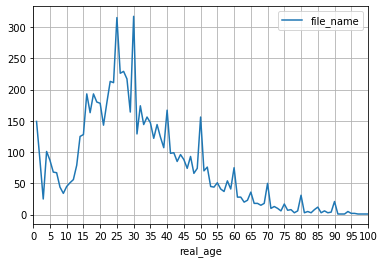

In [5]:
age = labels.groupby('real_age').count()
age.plot(grid=True)
plt.xticks(range(0,101,5))
plt.show()

Больше всего данных о людях в возрасте 25-30 лет. Подозрительно много людей, возраст которых 0 лет. Возможно, мы и правда имеем фото младенцев, а может быть это ошибки в данных.

В данных достаточно мало фотографий пожилых людей. Для увеличения количества примеров применим horisontal flip при выгрузке фотографий из файлов.

Пики на круглых значениях возраста могут быть из-за того, что многие люди округляют свой возраст, когда их просят его назвать.

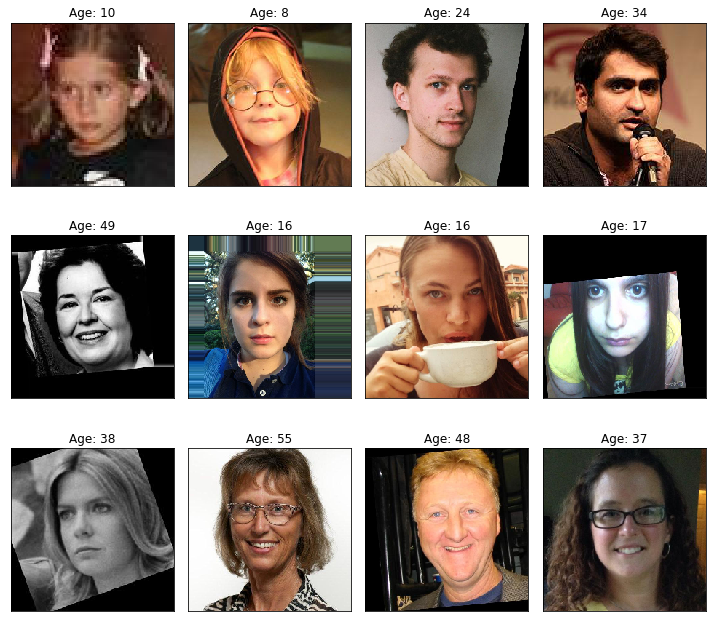

In [13]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(f"Age: {target[i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях видно, что лицо занимает бОльшую часть фото, что хорошо, потому что достаточно большой процент пикселей "полезных" для обучения модели.

На некоторых фотографиях присутствует незначительный угол поворота

Качество фотографий, в основном, достаточное для того, чтобы на глаз без труда разобрать лицо человека, в т.ч. с мелкими особенностями вроде родинок, морщин и т.д.

## Обучение модели

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
 
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    labels = pd.read_csv(path+'labels.csv')
 
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow
 

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    labels = pd.read_csv(path+'labels.csv')
 
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
    

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                        weights = 'imagenet',
                        include_top = False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, validation_data=test_data,
              epochs=epochs,batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 45s - loss: 217.1247 - mae: 10.6941 - val_loss: 652.4967 - val_mae: 20.5232

Epoch 2/10

356/356 - 37s - loss: 70.4727 - mae: 6.4110 - val_loss: 236.9259 - val_mae: 11.9771

Epoch 3/10

356/356 - 37s - loss: 39.0588 - mae: 4.8098 - val_loss: 82.7362 - val_mae: 6.8427

Epoch 4/10

356/356 - 37s - loss: 25.7932 - mae: 3.9514 - val_loss: 81.6850 - val_mae: 6.9790

Epoch 5/10

356/356 - 37s - loss: 18.4685 - mae: 3.2993 - val_loss: 80.8495 - val_mae: 6.9828

Epoch 6/10

356/356 - 37s - loss: 13.5033 - mae: 2.8108 - val_loss: 73.5467 - val_mae: 6.5639

Epoch 7/10

356/356 - 37s - loss: 12.3751 - mae: 2.6752 - val_loss: 67.6592 - val_mae: 6.2372

Epoch 8/10

356/356 - 37s - loss: 12.4990 - mae: 2.6921 - val_loss: 83.6905 - val_mae: 7.2031

Epoch 9/10

356/356 - 37s - loss: 11.9144 - mae: 2.6083 - val_loss: 76.1232 - val_mae: 6.4481

Epoch 10/10

356/356 - 37s - loss: 10.3404 - mae: 2.4242 - val_loss: 66.3835 - val_mae: 6.2053

119/119 - 9s - loss: 66.3835 - mae: 6.2053

Test MAE: 6.2053

**Результат после добавления horizontal_flip**


Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 118s - loss: 202.5478 - mae: 10.4369 - val_loss: 597.4041 - val_mae: 19.3130

Epoch 2/10

356/356 - 37s - loss: 83.3954 - mae: 6.9469 - val_loss: 170.8114 - val_mae: 9.8828

Epoch 3/10

356/356 - 37s - loss: 58.8773 - mae: 5.8554 - val_loss: 74.4710 - val_mae: 6.5282

Epoch 4/10

356/356 - 37s - loss: 41.0741 - mae: 4.8874 - val_loss: 74.7196 - val_mae: 6.5792

Epoch 5/10

356/356 - 37s - loss: 33.4498 - mae: 4.3912 - val_loss: 72.2843 - val_mae: 6.5109

Epoch 6/10

356/356 - 37s - loss: 25.3755 - mae: 3.8649 - val_loss: 75.9006 - val_mae: 6.6827

Epoch 7/10

356/356 - 37s - loss: 21.0902 - mae: 3.5129 - val_loss: 73.8529 - val_mae: 6.4339

Epoch 8/10

356/356 - 37s - loss: 18.1488 - mae: 3.2294 - val_loss: 79.2909 - val_mae: 6.6569

Epoch 9/10

356/356 - 37s - loss: 15.8231 - mae: 3.0233 - val_loss: 68.8235 - val_mae: 6.1512

Epoch 10/10

356/356 - 37s - loss: 13.6501 - mae: 2.8336 - val_loss: 66.9022 - val_mae: 6.1502

119/119 - 9s - loss: 66.9022 - mae: 6.1502

Test MAE: 6.1502

После добавления horizontal_flip результат на валидационной выборке немного улучшился.

## Анализ обученной модели

В ходе работы была создана модель на основе архитектуры ResNet50, с добавлением одного Dense слоя с 1 нейроном на выходе, т.к. решается задача регрессии.

Обучение модели происходило достаточно быстро на удаленном сервере с GPU оборудованием. Время обучения одной эпохи составило 37 сек. По прошествии 10 эпох было достигнуто значение MAE на тестовой выборке равное 6,15. 

Полученный результат удовлетворяет всем требованиям, поставленнным в данной задаче

Полученный результат может быть применен для первой бизнес задачи - предложение товаров, соответствующих возрастной группе. Полученное значение MAE не повредит определению возрастной группы, т.к. это понятие достаточно широкое и отклонение в несколько лет скорее всего ничего не изменит. А вот для проверки продавцов на добросовессность при продаже алкоголя данная модель работать не может. Т.к. в данной задаче важна гораздо большая точность, и гораздо выше цена ошибки модели, потому что речь идёт о серьезном нарушении закона при ошибке определения возраста.